In [1]:
# libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
import os
import datetime
from clodsa.augmentors.augmentorFactory import createAugmentor
from clodsa.transformers.transformerFactory import transformerGenerator
from clodsa.techniques.techniqueFactory import createTechnique

In [2]:
# paths
image_path = 'archive\\image\\image\\01012020_172204image853193.jpg'
train_path = 'archive\\image\\image'

# Augmentation of train set

# input parameters clodsa
PROBLEM = "instance_segmentation"
ANNOTATION_MODE = "coco"
INPUT_PATH = ".\\archive\\image\\image\\" # you have to put the \\ at the end for opening the desired folder
GENERATION_MODE = "linear"

# output parameters clodsa
OUTPUT_MODE = "coco"
OUTPUT_PATH= ".\\archive\\image\\image_augmentation\\" # you have to put the \\ at the end for opening the desired folder



## Analysis of data

In [3]:
# Read the JSON file
with open('./archive/train.json', 'r') as file:
    data = json.load(file)

# Prepare the list to store the extracted information
data_list = []

# keys of data are the name of images
# Extract information from the JSON data

for image_name, image_info in data.items():
    for region in image_info['regions']:
        region_data = {
            'name': image_name,
            'all_x': region['all_x'],
            'all_y': region['all_y'],
            'class': region['class']
        }
        data_list.append(region_data)

# Create a DataFrame from the extracted information
df = pd.DataFrame(data_list)

the keys of data are the name of the images. Each name of the image has a dict associated with the name of the image ('name') 
and  a list (the key is called 'region') with dictionaries indicating the different damages of the car. Each of the 
damage is a dictionary with attributes all_x, all_y and class:

* all_x: x coordinates of the polygon
* all_y: y coordinates of the polygon
* classes: class of the damage

**Classes explanation**

* mat_bo_phan=lost parts (Miscellaneous Damage)
* rach=torn (Metal damage tear)
* mop_lom=dented (Metal damage dent)
* tray_son=paint scratches (Metal damage scratches)
* thung=puncture (Miscellaneous Damage)
* vo_kinh=broken glass (Glass damage crack)
* be_den= broken lamp (Miscellaneous Damage)


Create the rectangles indicating the damages

In [4]:
def calculate_bounding_box(row):
    """
   Obtain the rectangles to indicate the damages of the car.

    Args:
        row (pd.Series): series of the damage of the image.

    Returns:
        rectangle (pd.Series): serie of the rectangle of the damage.
    """    
    min_x = min(row['all_x'])
    max_x = max(row['all_x'])
    min_y = min(row['all_y'])
    max_y = max(row['all_y'])
    
    x = min_x
    y = min_y
    width = max_x - min_x
    height = max_y - min_y

    rectangle = pd.Series([x, y, width, height], index=['x_rect', 'y_rect', 'width_rect', 'height_rect'])  
    return rectangle

# The calculation of the boxes is done to each row (each damage)
bounding_boxes = df.apply(calculate_bounding_box, axis=1)

In [5]:
# add the boxes to the dataframe
df = df.join(bounding_boxes)
df.head(2)

,name,all_x,all_y,class,x_rect,y_rect,width_rect,height_rect
0,01012020_172204image853193.jpg,"[1, 30, 81, 79, 74, 65, 63, 65, 83, 100, 126, ...","[107, 118, 184, 157, 131, 98, 86, 83, 110, 165...",mat_bo_phan,1,1,446,577
1,01012020_172204image853193.jpg,"[395, 457, 528, 621, 667, 705, 752, 772, 792, ...","[256, 264, 267, 267, 268, 277, 294, 301, 300, ...",rach,389,231,410,70


The number of elements by classes is checked. It can be seen that the data is not balanced. Therefore, it will be done a data augmentation to gain more information about the classes

In [6]:
print("Number of elments classification:",df.shape)
print("Number of photos:", len(df["name"].unique()))
print(df["class"].value_counts())

Number of elments classification: (30046, 8)
Number of photos: 11621
class
tray_son       12267
mop_lom         4709
rach            4546
mat_bo_phan     2370
be_den          2324
thung           2006
vo_kinh         1824
Name: count, dtype: int64


## Example

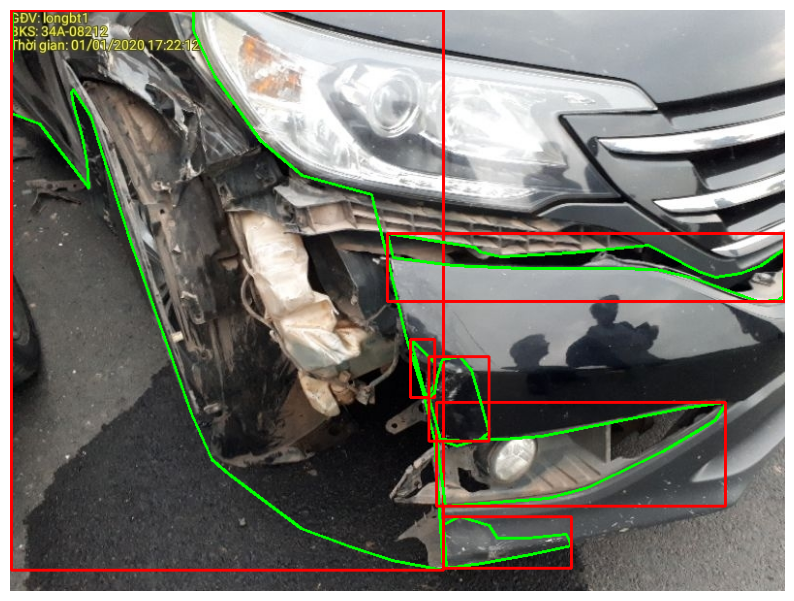

In [7]:
df_example = df[df["name"]=="01012020_172204image853193.jpg"]

image = cv2.imread(image_path)

# IMage is converted to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plotting the boxes and polygons of the image
for index, row in df_example.iterrows():
    # Coordinates of the polygon
    polygon_points = np.array(list(zip(row['all_x'], row['all_y'])), np.int32)
    polygon_points = polygon_points.reshape((-1, 1, 2))
    # Potting the polygon
    cv2.polylines(image_rgb, [polygon_points], isClosed=True, color=(0, 255, 0), thickness=2)
    
    # Box 
    x_rect = int(row['x_rect'])
    y_rect = int(row['y_rect'])
    width = int(row['width_rect'])
    height = int(row['height_rect'])
    
    # Poltting the box
    cv2.rectangle(image_rgb, (x_rect, y_rect), (x_rect + width, y_rect + height), (255, 0, 0), 2)

# Showing an example
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')  
plt.show()

## Images to tensor


In [8]:


# # Function to get image paths and labels from a folder
# def get_image_paths_labels(folder):
#     image_paths = []
#     labels = []
#     for filename in os.listdir(folder):  # List all files in the folder
#         if filename.endswith(('.jpg', '.jpeg', '.png')):  # Check if the file is an image
#             img_path = os.path.join(folder, filename)  # Get the full path to the image
#             image_paths.append(img_path)
#             labels.append(filename)  # Use the filename as the label (you may change this as needed)
#     return image_paths, labels

# # Get image paths and labels
# image_paths, labels = get_image_paths_labels(train_path)

# # Create a Pandas df to store the image paths and labels
# df = pd.DataFrame({'image_path': image_paths, 'label': labels})


# # Function to load and preprocess images
# def load_and_preprocess_image(path, label):
#     image = tf.io.read_file(path)  # Read the image file
#     image = tf.image.decode_jpeg(image, channels=3)  # Decode the JPEG image (use decode_png for PNG images)
#     image = tf.image.resize(image, [224, 224])  # Resize the image to 224x224 pixels
#     return image, label

# # Convert image paths and labels to tensors
# image_paths_tensor = tf.constant(df['image_path'].values) # array with path of images
# labels_tensor = tf.constant(df['label'].values) # name of images

# # Create a TensorFlow dataset from the tensors
# dataset = tf.data.Dataset.from_tensor_slices((image_paths_tensor, labels_tensor))

# # Apply the load_and_preprocess_image function to each element in the dataset
# dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# dataset

## Data Augmentation


Data augmentation 
The library that is going to be used is clodsa (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6567576/). There are some examples in the github page https://github.com/joheras/CLoDSA. This library not only will perform the changes to the image but also to the coordinates of the boxes and polygons associated to the image.

For that, the information about the images must be in COCO format (https://auto.gluon.ai/stable/tutorials/multimodal/object_detection/data_preparation/convert_data_to_coco_format.html)



In [9]:

# For being able to apply the augmentation, the json of the training needs to be in coco format and the width and
# height has to be in the dataframe

df["width"] = pd.NA
df["height"] = pd.NA

# name of training images
img_names = os.listdir(train_path)

# adding the width and the height of each of the images
for name in img_names:
    img_path = os.path.join(train_path, name)
    img = cv2.imread(img_path)

    if img is not None:
        height, width, _ = img.shape
        df.loc[df[df["name"] == name].index, "width" ] = width
        df.loc[df[df["name"] == name].index, "height" ]= height


In [10]:

def dataframe_to_coco_format(df, categories):
    """
   Convert DataFrame to COCO format.

    Args:
        df (pd.DataFrame): DataFrame with the data.
        categories (list): list of categories.

    Returns:
        dict: dictionary in COCO format.
    """
    coco_format = {
        "info": {
            "description": "Vehide",
            "url": "https://www.kaggle.com/datasets/syedanwarafridi/vehicle-sales-data",
            "version": "0.1.0",
            "year": '2024',
            "contributor": "Daniel_Teresa",
            "date_created": 'datetime.datetime.now().isoformat()'
        },
        "licenses": [
            {
                "id": 1,
                "name": "",
                "url": ""
            }
        ],
        "categories": [
            {"id": i + 1, "name": name, "supercategory": "car_damage"} for i, name in enumerate(categories)
        ],
        "images": [],
        "annotations": []
    }
    
    for id, image_name in enumerate(df["name"].unique()):
        df_image = df[ df["name"]== image_name]
        row = df_image.iloc[0]
        image_info = {
                "id": id + 1,
                "file_name": row['name'],
                "width": row['width'],
                "height": row['height'],
                "date_captured": datetime.datetime.now().isoformat(),
                "license": 1,
                "coco_url": "",
                "flickr_url": ""
            }
        coco_format["images"].append(image_info)  
        
        annotation_id = 1
        for idx, row in df_image.iterrows():
            bbox = [row['x_rect'], row['y_rect'], row['width_rect'], row['height_rect']]
            area = row['width_rect'] * row['height_rect']
            segmentation = []
            for x,y in zip(row['all_x'], row['all_y']):
                segmentation.append(x)
                segmentation.append(y)
            annotation = {
                    "id": annotation_id,
                    "image_id": id + 1,
                    "category_id": categories.index(row['class']) + 1,
                    "iscrowd": 0,
                    "area": area,
                    "bbox": bbox,
                    "segmentation": [segmentation],
                    "width": row['width'], #WIDTH CHECKEAR
                    "height": row['height']
            }
            coco_format["annotations"].append(annotation)
            annotation_id += 1
            
    return coco_format



In [11]:
# Convert to JSON string
coco_format = dataframe_to_coco_format(df, list(df["class"].unique()))
coco_json = json.dumps(coco_format, indent=4)

# Save to a JSON file
with open(".\\archive\\image\\image\\annotations.json", 'w') as f:
    f.write(coco_json)

In [12]:
df.to_csv("df_width_height.csv")

The techniques applied to the images are flip, rotation and Gaussian noise. All the new images will be stored in the folde image_aumentation and a new annotation.json will be created with the changes.

In [14]:
# creating output folder
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

# create our augmentor object.
augmentor = createAugmentor(PROBLEM,ANNOTATION_MODE,OUTPUT_MODE,GENERATION_MODE,INPUT_PATH,{"outputPath":OUTPUT_PATH})
# define a transformer generator.
transformer = transformerGenerator(PROBLEM)

# techniques applied to the photos

# rotation
for angle in [90,180]:
    rotate = createTechnique("rotate", {"angle" : angle})
    augmentor.addTransformer(transformer(rotate))

# flip
flip = createTechnique("flip",{"flip":1})
augmentor.addTransformer(transformer(flip))

# Gaussian noise
Gnoise = createTechnique("gaussian_noise", {"mean" : 0,"sigma":10})
augmentor.addTransformer(transformer(Gnoise))

augmentor.applyAugmentation()        

The code below is in case the augmentation procedures are applied separately (each on to a different output folder) and all the outputs are then put together as the result obtained if all the methods are applied joinly.

In [ ]:
# def change_name_images(image_folder, annotations_file, rename, name_old):
#     """
#     Function to change the first letters of the augmented photos in case that the methods are computed
#     separately.

#     Args:
#         image_folder (str): path of the folder with the images.
#         annotations_file (str): path of the COCO format json of the images.
#         rename (str): new start of the photos' name.
#         name_old (str): start of the photos' name to update.

#     """
#     # Rename images



#     # update images name
#     for filename in os.listdir(image_folder):
#         if filename.startswith(name_old):
#             new_filename = rename + filename[2:]
#             os.rename(os.path.join(image_folder, filename), os.path.join(image_folder, new_filename))

#     # update images name in json
#     with open(annotations_file, 'r') as file:
#         annotations = json.load(file)

#     # change names in json
#     for image_info in annotations['images']:
#         if image_info['file_name'].startswith(name_old):
#             image_info['file_name'] = rename + image_info['file_name'][2:]

#     # save changes
#     with open(annotations_file, 'w') as file:
#         json.dump(annotations, file, indent=4)


In [ ]:
# image_folder = ".\\archive\\image\\augmentation2\\"
# annotations_file = os.path.join(image_folder, 'annotation.json')
# rename = '2_'
# name_old = '0_'
# change_name_images(image_folder, annotations_file, rename, name_old)

# image_folder = ".\\archive\\image\\augmentation3\\"
# annotations_file = os.path.join(image_folder, 'annotation.json')
# rename = '3_'
# name_old = '0_'
# change_name_images(image_folder, annotations_file, rename, name_old)

In [ ]:
# def merge_coco_annotations(file1, file2, output_file):
#     # open json files
#     with open(file1, 'r') as f:
#         data1 = json.load(f)
#     with open(file2, 'r') as f:
#         data2 = json.load(f)

#     # Initialize the combined json
#     combined = {
#         "info": data1["info"],
#         "licenses": data1["licenses"],
#         "images": [],
#         "annotations": [],
#         "categories": data1["categories"]
#     }

#     # Value of the max. index in "image" and "annotation"
#     max_image_id = max(image["id"] for image in data1["images"]) if data1["images"] else 0
#     max_annotation_id = max(ann["id"] for ann in data1["annotations"]) if data1["annotations"] else 0

#     # First, add elements of the first json
#     combined["images"].extend(data1["images"])
#     combined["annotations"].extend(data1["annotations"])

#     # Function to update the  indexes
#     def update_ids(data, image_id_offset, annotation_id_offset):
#         for image in data["images"]:
#             image["id"] += image_id_offset
#         for annotation in data["annotations"]:
#             annotation["id"] += annotation_id_offset
#             annotation["image_id"] += image_id_offset

#     # Update the indexes of the second json and it is 
#     # added to the combined json
#     update_ids(data2, max_image_id + 1, max_annotation_id + 1)
#     combined["images"].extend(data2["images"])
#     combined["annotations"].extend(data2["annotations"])

#     print(len(data1["images"]))
#     print(len(data2["images"]))
#     print(len(combined["images"]))
#     # save the json
#     with open(output_file, 'w') as f:
#         json.dump(combined, f, indent=4)

# # 


In [ ]:
# file1 = '.\\archive\\image\\augmentation\\annotation.json'
# file2 = '.\\archive\\image\\augmentation2\\annotation.json'
# output_file = '.\\archive\\image\\annotation.json'

# merge_coco_annotations(file1, file2, output_file)

# file1 = '.\\archive\\image\\annotation.json'
# file2 = '.\\archive\\image\\augmentation3\\annotation.json'
# output_file = '.\\archive\\image\\annotation.json'

# merge_coco_annotations(file1, file2, output_file)

In [ ]:

# Especifica las rutas de la carpeta de origen y destino
# source_folder = '.\\archive\\image\\augmentation3\\'
# destination_folder = '.\\archive\\image\\image_augmentation\\'

# def move_images(source_folder, destination_folder):
#     if not os.path.exists(destination_folder):
#         os.makedirs(destination_folder)

#     for filename in os.listdir(source_folder):
#         if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff')):
#             # Construye la ruta completa del archivo de origen y destino
#             source_path = os.path.join(source_folder, filename)
#             destination_path = os.path.join(destination_folder, filename)
            
#             # Mueve el archivo a la carpeta de destino
#             os.rename(source_path, destination_path)

# move_images(source_folder, destination_folder)            

In [ ]:
def image_coco_plot(path, annotation_json, image_name):
    """
    Display a photo and its polygons from a coco format json

    Args:
        path (str): path of the folder with the images and the json with the annotations.
        annotations_json (str): path  of the file of the annotations.
        image_name (str): name of the photo to display.
    """


    # Load the annotations JSON file
    annotations_path =  annotation_json
    with open(annotations_path, 'r') as file:
        annotations = json.load(file)

    # Extract the information for the specific image
    image_filename = image_name
    image_info = None
    for image in annotations['images']:
        if image['file_name'] == image_filename:
            image_info = image
            break

    if image_info is None:
        raise ValueError(f"Image {image_filename} not found in annotations.")

    image_id = image_info['id'] # take the id for the annotations part

    # Extract annotations for the image
    image_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == image_id]

    # Load the image
    image_path = path + image_filename
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw the polygons and rectangles
    for ann in image_annotations:
        if 'segmentation' in ann:
            x_coords = []
            y_coords = []

            # Separar las coordenadas en x e y
            for i in range(0, len(ann['segmentation'][0]), 2):
                x_coords.append(ann["segmentation"][0][i])
                y_coords.append(ann["segmentation"][0][i + 1])

            polygon_points = np.array(list(zip(x_coords, y_coords)), np.int32)
            polygon_points = polygon_points.reshape((-1, 1, 2))
            # Dibujar el polígono
            cv2.polylines(image_rgb, [polygon_points], isClosed=True, color=(0, 255, 0), thickness=2)
        
        # Draw the bounding box (if any)
        if 'bbox' in ann:
            bbox = ann['bbox']
            # rectangle coordiantes
            x_rect = int(ann['bbox'][0])
            y_rect = int(ann['bbox'][1])
            width = int(ann['bbox'][2])
            height = int(ann['bbox'][3])
            
            # Dibujar el rectángulo
            cv2.rectangle(image_rgb, (x_rect, y_rect), (x_rect + width, y_rect + height), (255, 0, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')  # Ocultar los ejes
    plt.show()
    

In [ ]:
path = OUTPUT_PATH
annotation_json= ".\\archive\\image\\annotation0.json" 
image_name = '0_01012020_172204image853193.jpg'
image_coco_plot(path, annotation_json, image_name)

# Precios
* Broken lamp (100-400 euros) (https://seguros.check24.es/seguros-de-coche/guias/cambiar-faros-coche/#:~:text=En%20Espa%C3%B1a%2C%20el%20precio%20medio,mano%20de%20obra%20del%20taller.)
* Broken glass 70-600 (300-600 change of  the glass) (https://www.race.es/circular-luna-delantera-rajada#:~:text=%C2%BFCu%C3%A1nto%20cuesta%20cambiar%20una%20luna,el%20peor%20de%20los%20casos. https://www.dpsportauto.es/posts/luna-rota-cuanto-cuesta-su-reparacion) (https://www.airtasker.com/ie/costs/windscreen-repair-replacement/cost-of-windscreen-repairs-and-replacement/)
* dented: 50-2500  50-450/ 50-1500 (https://www.way.com/es/blog/arreglar-la-puerta-del-auto-abollada/#:~:text=%C2%BFCu%C3%A1l%20es%20el%20coste%20de,est%C3%A1%20entre%20%2450%20y%20%242500 / https://www.insurancenavy.com/es/costo-de-arreglar-puerta-de-carro/#:~:text=Las%20abolladuras%20y%20rasgu%C3%B1os%20peque%C3%B1os,alrededor%20de%20%24150%20a%20%24450. https://phillongbodyshop.com/collision-repair-cost-calculator.html)
* paint scratches 100-150 una pieza, 750-1700 pintar todo el coche, PINTURA RANGO TODO 50-1500 https://www.20minutos.es/motor/movilidad/cuanto-cuesta-reparar-un-aranazo-en-el-coche-4832668/ https://phillongbodyshop.com/collision-repair-cost-calculator.html
* torn  50- 1500 https://phillongbodyshop.com/collision-repair-cost-calculator.html
* lost parts
* puncture